# Prédiction des émissions de CO2 d'un véhicule en fonction de ces caractéristiques

- Import des libraries et des données

In [1]:
# libraries used for data exploration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimpy import skim
from scipy.stats import kurtosis, skew
import pingouin as pg

# librairies used for machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor, export_text

# utils
import gc
from scipy.stats import randint

import warnings
warnings.filterwarnings('ignore')

In [2]:
def distribution_analysis(dataframe, variable, dataframe_and_variable):
    sns.histplot(
    data = dataframe,
    x = variable,
    kde=True
    )

    plt.title(f"Distribution de la variable {variable}")
    plt.show()
    
    skewness = skew(dataframe_and_variable)
    kurtosis_var = kurtosis(dataframe_and_variable)
    normality = pg.normality(
        dataframe_and_variable,
        method="normaltest"
        )

    print(f"Skewness : {skewness}  - Kurtosis : {kurtosis_var}\nTest de normalité de la distribution\n{normality}")

def numerical_analysis(dataframe, variable):
    sns.boxplot(
    x=variable,
    data=dataframe
    )
    plt.title(f'Boîte à moustaches de la variable {variable}')
    plt.show()

    print(dataframe[variable].describe())

def categorical_analysis(dataframe, variable):
    sns.countplot(
        x = variable,
        data = dataframe,
        stat="percent"
    )
    plt.title(f"Répartition des véhicules en fontion de la variable : {col}")
    plt.ylabel("Pourcentage (%)")
    plt.xticks(rotation=90)
    plt.show()

def linear_regression_analysis(dataframe, variable, target):
    sns.lmplot(
        data=dataframe,
        x=target,
        y=variable
        )
    plt.title(f"Interaction entre {target} et {variable}")
    plt.show()
    lm = pg.linear_regression(dataframe[target], dataframe[variable])
    print(lm.round(2))

def categorical_relation(dataframe, variable, target):
    sns.boxplot(
        data=dataframe,
        x=variable, 
        y=target
        )
    plt.title(f"Interaction entre {target} et {variable}")
    plt.xticks(rotation=90)
    plt.show()

    aov = pg.anova(
        dv=target,
        between=variable,
        data=dataframe,
        detailed=True
        )
    print(aov.round(2))

In [3]:
PATH = "../datasets/dataset.csv"

In [4]:
df = pd.read_csv(PATH)
df.head()

,Marque,Modèle,Energie,Carrosserie,Cylindrée,Gamme,Puissance fiscale,Puissance maximale,Puissance nominale électrique,Poids à vide,...,Bonus-Malus,Conso basse vitesse,Conso moyenne vitesse,Conso haute vitesse,Conso T-haute vitesse,Conso vitesse mixte,Conso elec,Autonomie elec,Autonomie elec urbain,Emission CO2
0,renault,kangoo,essence,combispace,1332,inferieure,7,96.0,NaN,1519,...,malus,8.7405,6.7880,6.188,7.9175,7.2635,NaN,NaN,NaN,167.272
1,mazda,mx-30,electric,ts_terrains/chemins,0,inferieure,6,NaN,80.9,1645,...,bonus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ds,7_crossback,elec+essenc_hr,ts_terrains/chemins,1598,moyenne_superieure,10,133.0,30.0,1760,...,neutre,NaN,NaN,NaN,NaN,1.5340,162.5,58.5,67.5,NaN
3,renault,austral,ess+elec_hnr,ts_terrains/chemins,1199,moyenne_superieure,7,96.0,0.0,1421,...,neutre,6.5805,5.0200,4.834,5.9555,5.5025,NaN,NaN,NaN,126.073
4,b.m.w.,218,essence,monospace_compact,1499,moyenne_inferieure,7,100.0,NaN,1470,...,malus,8.9420,6.6295,5.637,6.4505,6.5680,NaN,NaN,NaN,155.826


## 1) Préparation des données

In [5]:
df.shape

(7679, 23)

In [6]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 7679   │ │ float64     │ 12    │                                                          │
│ │ Number of columns │ 23     │ │ string      │ 7     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 4     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name             ┃ NA    ┃ NA %   ┃ mean   ┃ sd     ┃ p0    ┃ p25   ┃ p50   ┃ p75   ┃ p100 ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━━┩  │
│ │ Cylindrée               │     0 │      0 │   1700 │    680 │     0 │  1400 │  1600 │  2000 │ 6700 │  ▂▇▁   │  │
│ │ Puissance fiscale       │     0 │      0 │     10 │    7.7 │     1 │     6 │     8 │    10 │   91 │   ▇▁   │  │
│ │ Puissance maximale      │   269 │    3.5 │    130 │     66 │    48 │    92 │   110 │   140 │  610 │  ▇▂▁   │  │
│ │ Puissance nominale      │  4925 │  64.14 │     25 │     32 │     0 │     0 │    10 │    48 │  200 │  ▇▂▁   │  │
│ │ électrique              │       │        │        │        │       │       │       │       │      │        │  │
│ │ Poids à vide            │     0 │      0 │   1600 │    340 │   840 │  1300 │  1500 │  1800 │ 2700 │ ▂▇▆▃▁  │  │
│ │ Rapport poids-puissance │     0 │      0 │  0.079 │  0.035 │     0 │  0.06 │  0.07 │  0.09 │ 0.37 │  ▃▇▁   │  │
│ │ Nombre rapports         │     0 │      0 │    6.7 │    1.9 │     0 │     6 │     7 │     8 │    9 │ ▁   ▇▆ │  │
│ │ Conso basse vitesse     │   989 │  12.88 │      8 │    2.2 │   3.2 │   6.7 │   7.8 │   8.9 │   30 │   ▇▇   │  │
│ │ Conso moyenne vitesse   │   989 │  12.88 │    6.1 │    1.3 │   3.3 │   5.2 │   5.9 │   6.7 │   18 │  ▆▇▁   │  │
│ │ Conso haute vitesse     │   989 │  12.88 │    5.4 │      1 │   3.7 │   4.7 │   5.3 │   5.8 │   14 │  ▇▆▁   │  │
│ │ Conso T-haute vitesse   │   989 │  12.88 │    6.5 │    1.1 │   4.2 │   5.7 │   6.3 │     7 │   14 │  ▅▇▂   │  │
│ │ Conso vitesse mixte     │   395 │   5.14 │    5.9 │    1.7 │  0.56 │   5.2 │     6 │   6.8 │   17 │  ▁▆▇   │  │
│ │ Conso elec              │  6861 │  89.35 │    200 │     42 │   130 │   160 │   190 │   240 │  290 │ ▇▇▅▃▆▂ │  │
│ │ Autonomie elec          │  6861 │  89.35 │    140 │    140 │    40 │    50 │    64 │   120 │  680 │  ▇ ▁▁  │  │
│ │ Autonomie elec urbain   │  6861 │  89.35 │    170 │    180 │    41 │    55 │    74 │   170 │  740 │ ▇  ▁▁  │  │
│ │ Emission CO2            │   989 │  12.88 │    150 │     31 │    93 │   140 │   150 │   160 │  410 │  ▇▇▁   │  │
│ └─────────────────────────┴───────┴────────┴────────┴────────┴───────┴───────┴───────┴───────┴──────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                  ┃ NA     ┃ NA %       ┃ words per row               ┃ total words             ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇

Les véhicules électriques n'émettent pas de CO2, ils sont enlevés du jeu de données pour la suite de l'analyse ainsi que pour la construction du modèle de prédiction. 

In [7]:
# remove electric vehicles
df = df[df["Energie"] != 'electric']

In [8]:
df.describe()

,Cylindrée,Puissance fiscale,Puissance maximale,Puissance nominale électrique,Poids à vide,Rapport poids-puissance,Nombre rapports,Conso basse vitesse,Conso moyenne vitesse,Conso haute vitesse,Conso T-haute vitesse,Conso vitesse mixte,Conso elec,Autonomie elec,Autonomie elec urbain,Emission CO2
count,7409.000000,7409.000000,7409.000000,2484.000000,7409.000000,7409.000000,7409.000000,6690.000000,6690.000000,6690.000000,6690.000000,7284.000000,594.000000,594.000000,594.000000,6690.000000
mean,1796.202322,10.229856,130.021055,20.157009,1555.344986,0.082061,6.928195,8.018916,6.075571,5.407636,6.464161,5.897295,199.928636,61.744613,68.052020,154.651505
std,609.909070,7.806961,66.386992,27.228414,333.232021,0.031618,1.553918,2.238887,1.254111,1.027638,1.135738,1.719087,40.243956,18.477725,19.951523,30.739784
min,875.000000,4.000000,48.000000,0.000000,840.000000,0.040000,0.000000,3.219000,3.327000,3.726000,4.238500,0.562000,133.500000,39.700000,41.350000,92.947000
25%,1469.000000,6.000000,91.900000,0.000000,1320.000000,0.060000,6.000000,6.663000,5.213500,4.709000,5.655000,5.243500,162.500000,48.000000,51.750000,135.540000
50%,1950.000000,8.000000,110.000000,8.000000,1490.000000,0.080000,7.000000,7.765000,5.912500,5.267500,6.296000,5.987000,192.850000,56.000000,61.000000,147.635000
75%,1995.000000,10.000000,140.000000,30.000000,1755.000000,0.090000,8.000000,8.862500,6.675500,5.840500,7.025000,6.752500,241.770000,74.000000,87.000000,164.659250
max,6749.000000,91.000000,607.000000,139.000000,2735.000000,0.370000,9.000000,29.914500,17.541500,13.632000,13.947000,16.521500,288.500000,112.000000,116.500000,411.010000


In [9]:
df.columns

Index(['Marque', 'Modèle', 'Energie', 'Carrosserie', 'Cylindrée', 'Gamme',
       'Puissance fiscale', 'Puissance maximale',
       'Puissance nominale électrique', 'Poids à vide',
       'Rapport poids-puissance', 'Type de boite', 'Nombre rapports',
       'Bonus-Malus', 'Conso basse vitesse', 'Conso moyenne vitesse',
       'Conso haute vitesse', 'Conso T-haute vitesse', 'Conso vitesse mixte',
       'Conso elec', 'Autonomie elec', 'Autonomie elec urbain',
       'Emission CO2'],
      dtype='object')

In [10]:
# create list to separe categorical & numerical variables
# remove the target variables 
categorical = list(df.dtypes[df.dtypes == 'object'].index)
numerical = [i for i in list(df.columns) if i not in categorical]
numerical.pop(-1)

'Emission CO2'

On remarque que les variables en lien avec la consommation électrique des véhicules présentent un grand nombre de variables manquantes. Cela s'explique par le fait que les véhicules thermiques classiques ne vont pas consommer d'électricité. On va donc remplacer ces valeurs par 0.

In [11]:
# fill variables about electric consumption

electrical_variables  = [
    "Autonomie elec",
    "Puissance nominale électrique",
    "Conso elec",
    "Autonomie elec urbain"
    ]

for col in electrical_variables:
    df[col] = df[col].fillna(0)

Concernant les autres variables numériques avec des valeurs manquantes ainsi que la variable cible, on complète les valeurs manquantes par la valeur médiane. 

In [12]:
# fill other numerical variables
for c in numerical:
    df[c] = df[c].fillna(df[c].median())

In [13]:
# fill target variable
df["Emission CO2"] = df["Emission CO2"].fillna(df["Emission CO2"].median())

In [14]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 7409   │ │ float64     │ 12    │                                                          │
│ │ Number of columns │ 23     │ │ string      │ 7     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 4     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name              ┃ NA  ┃ NA %  ┃ mean    ┃ sd     ┃ p0    ┃ p25   ┃ p50   ┃ p75   ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ Cylindrée                │   0 │     0 │    1800 │    610 │   880 │  1500 │  2000 │  2000 │  6700 │  ▇▆▁   │  │
│ │ Puissance fiscale        │   0 │     0 │      10 │    7.8 │     4 │     6 │     8 │    10 │    91 │   ▇▁   │  │
│ │ Puissance maximale       │   0 │     0 │     130 │     66 │    48 │    92 │   110 │   140 │   610 │  ▇▂▁   │  │
│ │ Puissance nominale       │   0 │     0 │     6.8 │     18 │     0 │     0 │     0 │     0 │   140 │   ▇    │  │
│ │ électrique               │     │       │         │        │       │       │       │       │       │        │  │
│ │ Poids à vide             │   0 │     0 │    1600 │    330 │   840 │  1300 │  1500 │  1800 │  2700 │ ▂▇▆▃▁  │  │
│ │ Rapport poids-puissance  │   0 │     0 │   0.082 │  0.032 │  0.04 │  0.06 │  0.08 │  0.09 │  0.37 │   ▇▁   │  │
│ │ Nombre rapports          │   0 │     0 │     6.9 │    1.6 │     0 │     6 │     7 │     8 │     9 │     ▇▆ │  │
│ │ Conso basse vitesse      │   0 │     0 │       8 │    2.1 │   3.2 │   6.8 │   7.8 │   8.7 │    30 │   ▆▇   │  │
│ │ Conso moyenne vitesse    │   0 │     0 │     6.1 │    1.2 │   3.3 │   5.3 │   5.9 │   6.6 │    18 │   ▅▇   │  │
│ │ Conso haute vitesse      │   0 │     0 │     5.4 │   0.98 │   3.7 │   4.8 │   5.3 │   5.8 │    14 │   ▇▅   │  │
│ │ Conso T-haute vitesse    │   0 │     0 │     6.4 │    1.1 │   4.2 │   5.7 │   6.3 │   6.9 │    14 │  ▅▇▂   │  │
│ │ Conso vitesse mixte      │   0 │     0 │     5.9 │    1.7 │  0.56 │   5.3 │     6 │   6.7 │    17 │  ▁▆▇   │  │
│ │ Conso elec               │   0 │     0 │      16 │     55 │     0 │     0 │     0 │     0 │   290 │   ▇    │  │
│ │ Autonomie elec           │   0 │     0 │       5 │     18 │     0 │     0 │     0 │     0 │   110 │   ▇    │  │
│ │ Autonomie elec urbain    │   0 │     0 │     5.5 │     19 │     0 │     0 │     0 │     0 │   120 │   ▇    │  │
│ │ Emission CO2             │   0 │     0 │     150 │     29 │    93 │   140 │   150 │   160 │   410 │  ▆▇▁   │  │
│ └──────────────────────────┴─────┴───────┴─────────┴────────┴───────┴───────┴───────┴───────┴───────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                  ┃ NA     ┃ NA %       ┃ words per row               ┃ total words             ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇

Les variables manquantes ont été supprimées, on peut donc passer à l'analyse exploratoire des doonées.

## 2) Analyse exploratoire des données

### a) Analyses univariées

#### Analyse de la variable cible

- Distribution de la variable cible : Emission de CO2

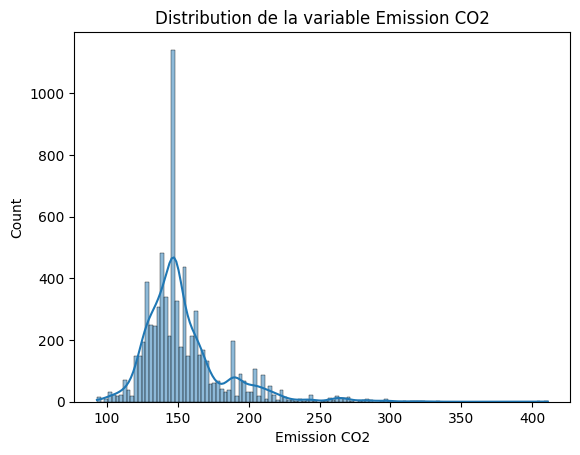

Skewness : 1.9030578601431554  - Kurtosis : 6.135454152993113
Test de normalité de la distribution
                        W  pval  normal
Emission CO2  3020.689266   0.0   False


In [15]:
distribution_analysis(df, "Emission CO2", df["Emission CO2"])

Le coefficient d'asymétrie (skewness) montre une asymétrie de la distribution et le kurtosis indique la présence d'un pic important dans la distribution des émissions de CO2. Enfin le test de normalité montre que la distribution ne suit pas la loi normale.

Il faudra donc effectuer une transformation logarithmique pour éviter que la forme de la distribution perturbe les modèles linéaires qui pourraient être utilisés dans notre recherche de modèle.

- Indices de tendance centrale et de dispersion : Emission de CO2

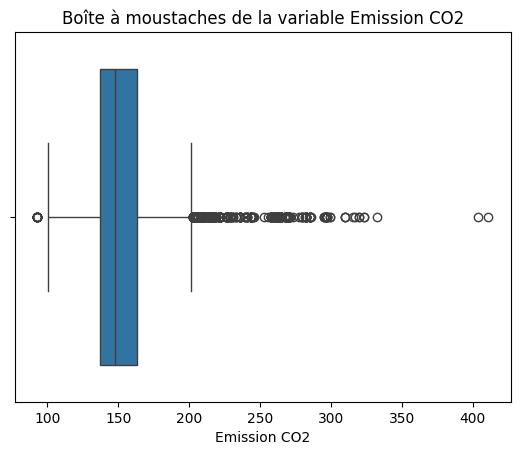

count    7409.000000
mean      153.970594
std        29.283719
min        92.947000
25%       137.293000
50%       147.635000
75%       162.945000
max       411.010000
Name: Emission CO2, dtype: float64


In [16]:
numerical_analysis(df, "Emission CO2")

Les émissions de CO2 sont comprises entre 92.947 g et 411.01 g. La moyenne est de 153.97g et la médiane de 147.63g. L'écart-type est de 29.28g et l'intervalle interquartile de 25.652g. 

In [17]:
# log transformation
df["Emission CO2"] = np.log1p(df["Emission CO2"])

#### Analyse des variables catégorielles

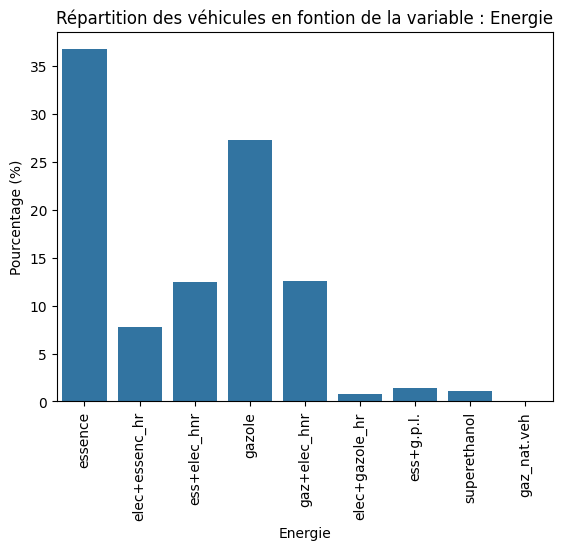

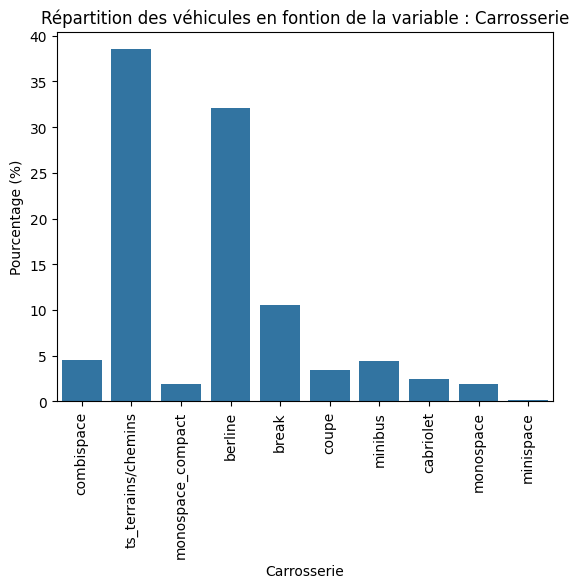

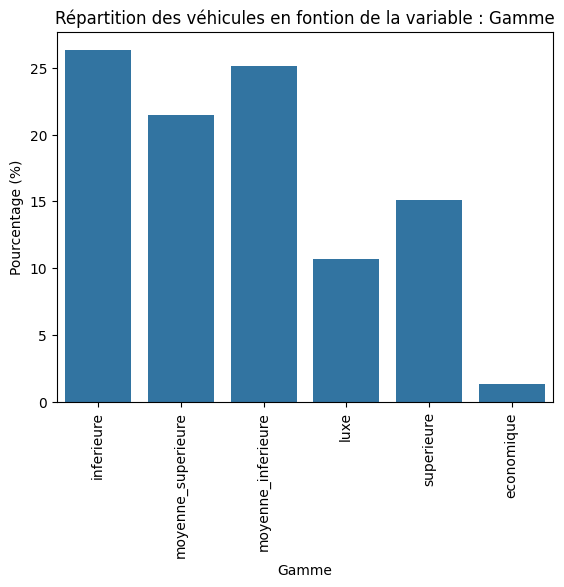

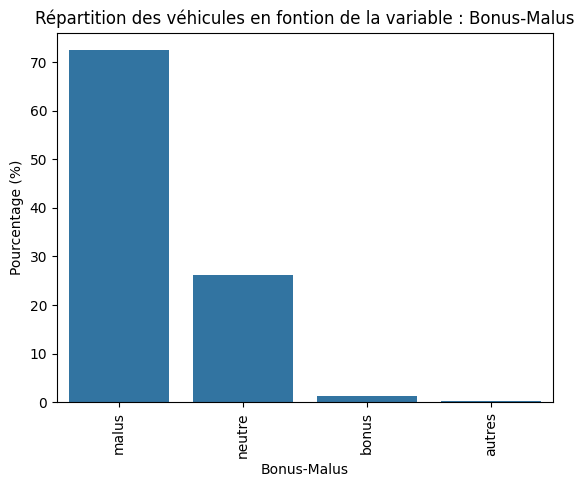

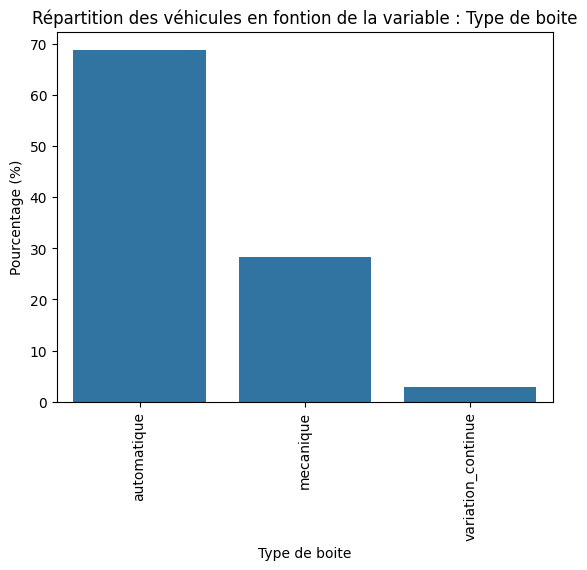

In [18]:
for col in ['Energie', 'Carrosserie', 'Gamme', 'Bonus-Malus', "Type de boite"]:
    categorical_analysis(df, col)

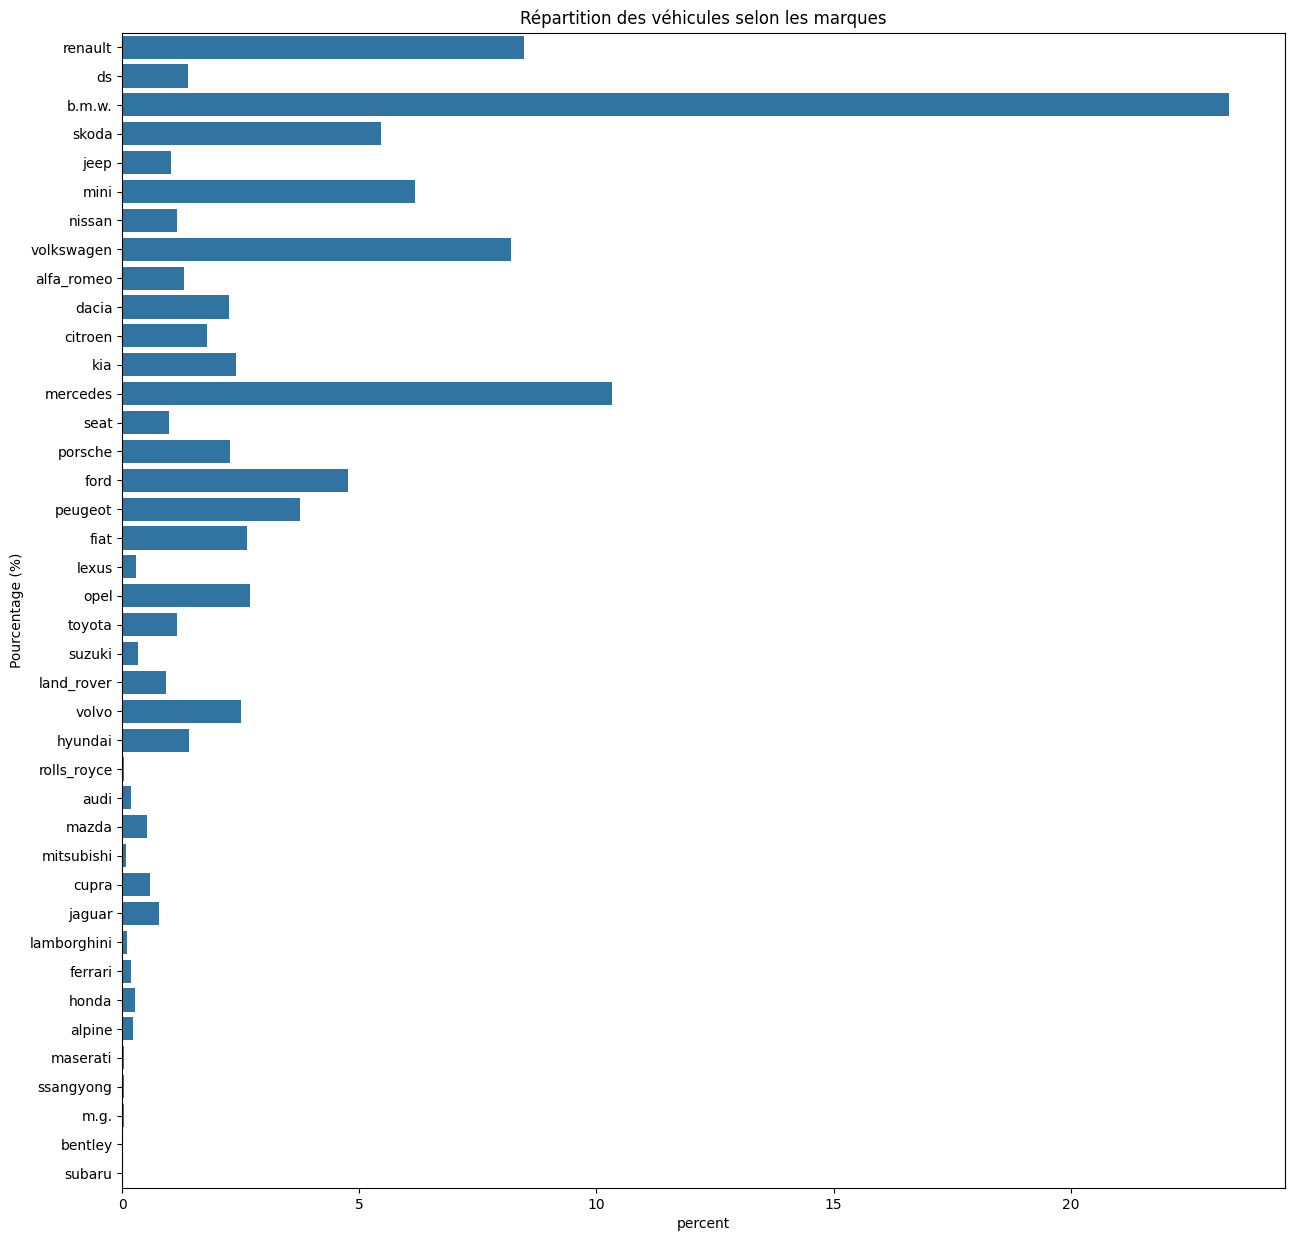

In [19]:
plt.figure(figsize=(15,15))

sns.countplot(
    y="Marque",
    data=df,
    stat="percent"
)
plt.ylabel("Pourcentage (%)")
plt.title(f"Répartition des véhicules selon les marques")
plt.show()

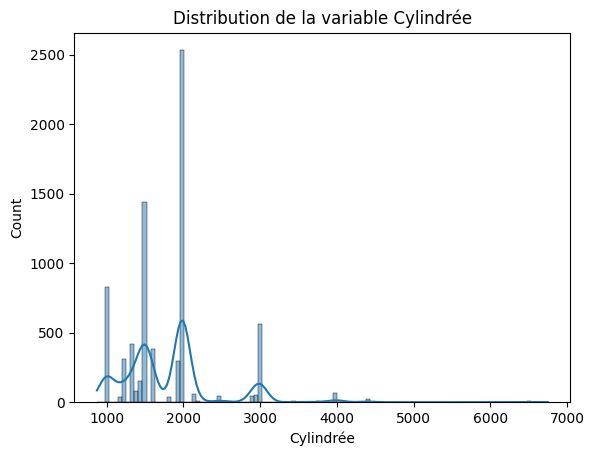

Skewness : 1.7211949069582582  - Kurtosis : 6.574486160014331
Test de normalité de la distribution
                     W  pval  normal
Cylindrée  2835.024416   0.0   False


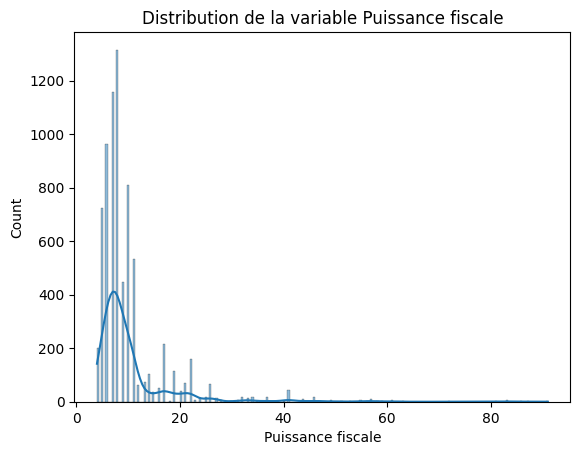

Skewness : 4.108970378934731  - Kurtosis : 23.799330194018996
Test de normalité de la distribution
                             W  pval  normal
Puissance fiscale  6387.477274   0.0   False


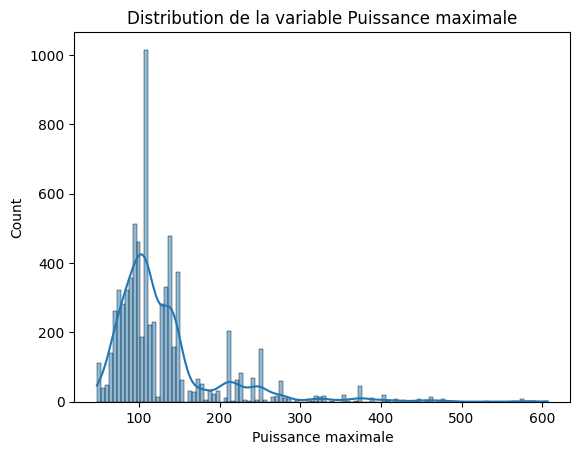

Skewness : 2.5147652388960506  - Kurtosis : 8.691945945356501
Test de normalité de la distribution
                             W  pval  normal
Puissance maximale  4002.92581   0.0   False


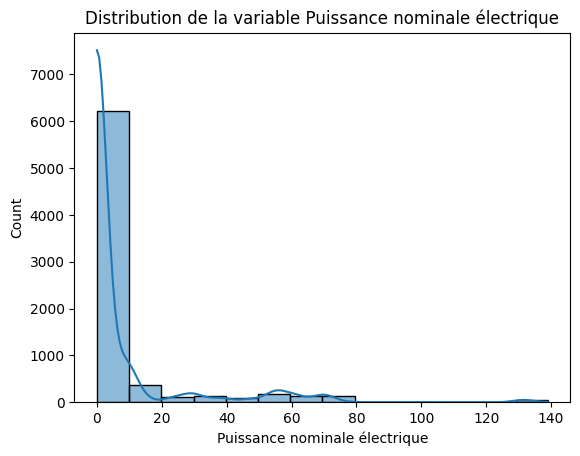

Skewness : 3.558875576222835  - Kurtosis : 14.726810577772309
Test de normalité de la distribution
                                         W  pval  normal
Puissance nominale électrique  5506.125695   0.0   False


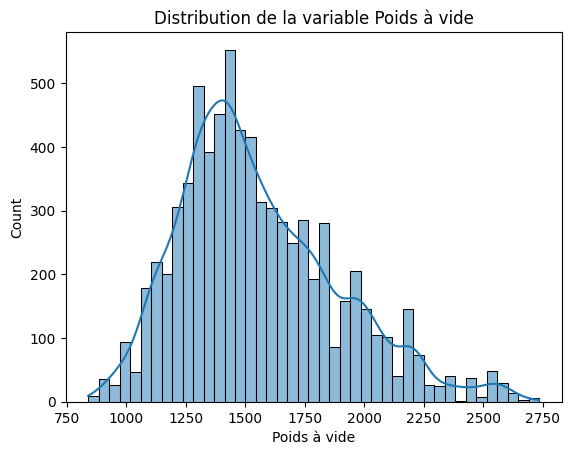

Skewness : 0.7343749796270034  - Kurtosis : 0.309296623513557
Test de normalité de la distribution
                      W           pval  normal
Poids à vide  562.17972  8.398949e-123   False


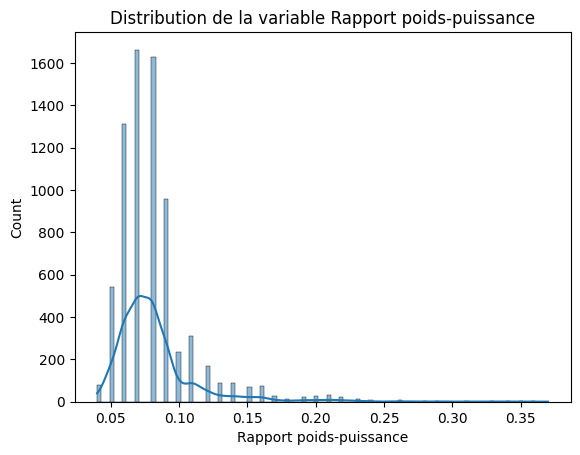

Skewness : 3.0901141209055227  - Kurtosis : 14.941066750693647
Test de normalité de la distribution
                                   W  pval  normal
Rapport poids-puissance  5038.619176   0.0   False


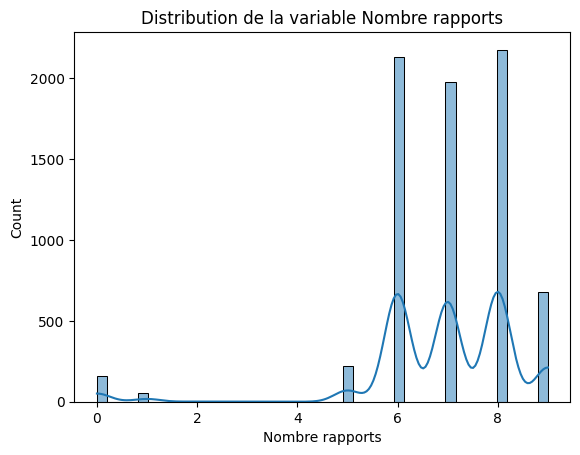

Skewness : -2.1733952677778263  - Kurtosis : 7.7331570203167
Test de normalité de la distribution
                          W  pval  normal
Nombre rapports  3515.45726   0.0   False


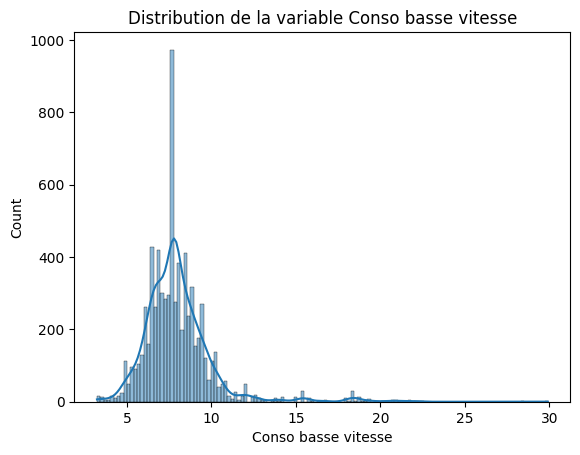

Skewness : 2.6117632148765044  - Kurtosis : 12.795587340521815
Test de normalité de la distribution
                               W  pval  normal
Conso basse vitesse  4398.663097   0.0   False


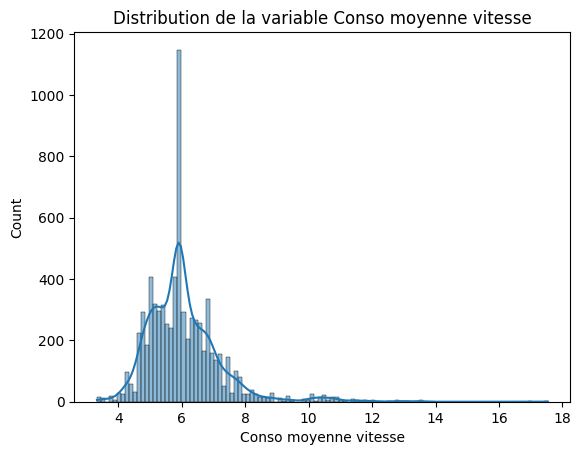

Skewness : 1.906038832824575  - Kurtosis : 7.668345920278538
Test de normalité de la distribution
                                 W  pval  normal
Conso moyenne vitesse  3178.327427   0.0   False


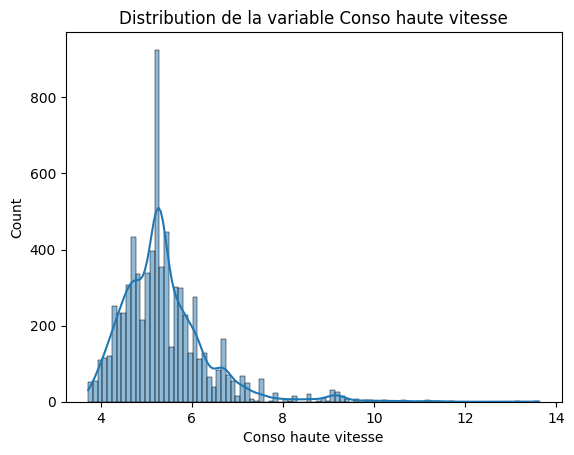

Skewness : 1.8618555618708243  - Kurtosis : 6.503469126637215
Test de normalité de la distribution
                               W  pval  normal
Conso haute vitesse  3007.943887   0.0   False


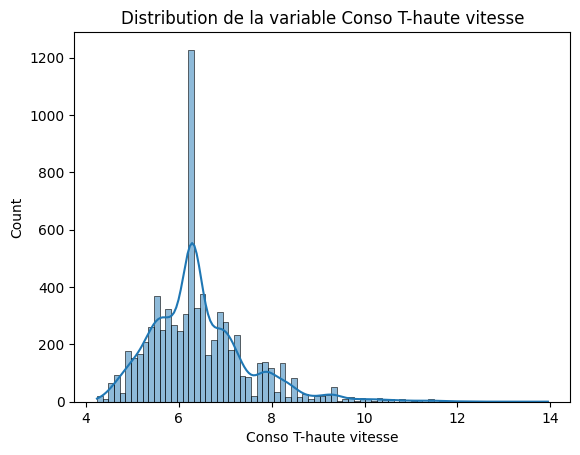

Skewness : 1.2372623406441277  - Kurtosis : 3.006215262663668
Test de normalité de la distribution
                                 W  pval  normal
Conso T-haute vitesse  1723.037383   0.0   False


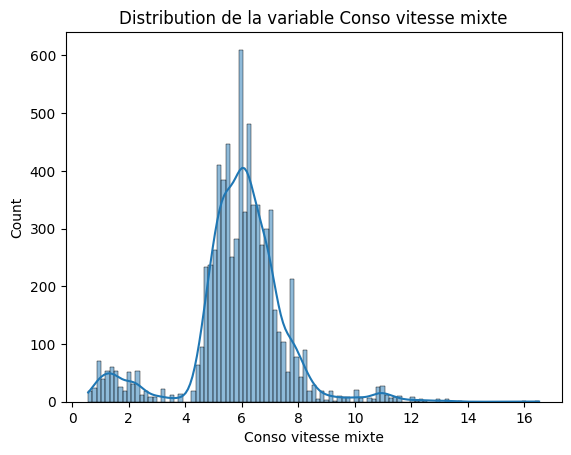

Skewness : -0.3630843673533579  - Kurtosis : 3.1597107464890266
Test de normalité de la distribution
                              W           pval  normal
Conso vitesse mixte  706.589079  3.682401e-154   False


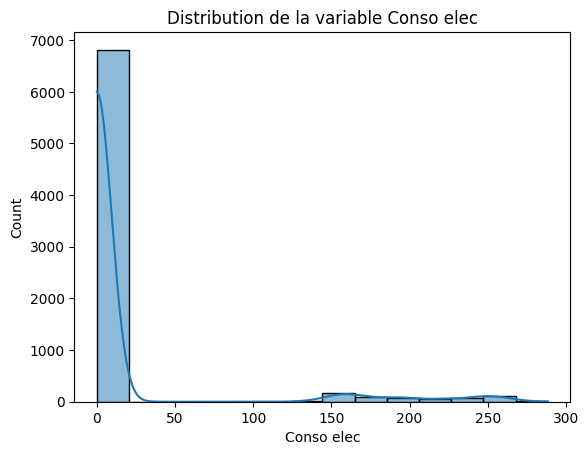

Skewness : 3.3250497581195115  - Kurtosis : 9.60217418055771
Test de normalité de la distribution
                     W  pval  normal
Conso elec  4953.78583   0.0   False


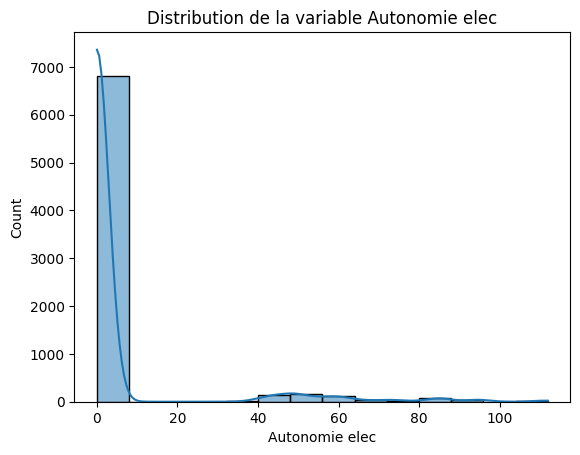

Skewness : 3.6428699935865083  - Kurtosis : 12.833264336647463
Test de normalité de la distribution
                          W  pval  normal
Autonomie elec  5485.376005   0.0   False


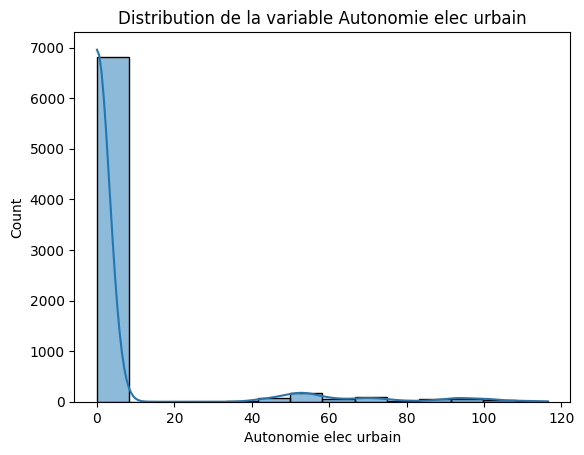

Skewness : 3.5909432458013812  - Kurtosis : 12.134224728449214
Test de normalité de la distribution
                                 W  pval  normal
Autonomie elec urbain  5392.760963   0.0   False


In [20]:
for col in numerical:
    distribution_analysis(df, col, df[col])

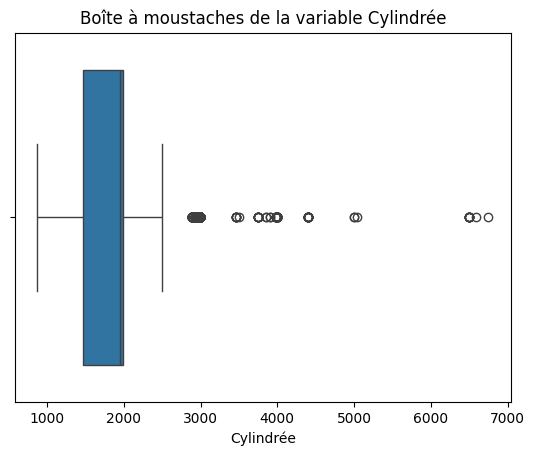

count    7409.000000
mean     1796.202322
std       609.909070
min       875.000000
25%      1469.000000
50%      1950.000000
75%      1995.000000
max      6749.000000
Name: Cylindrée, dtype: float64


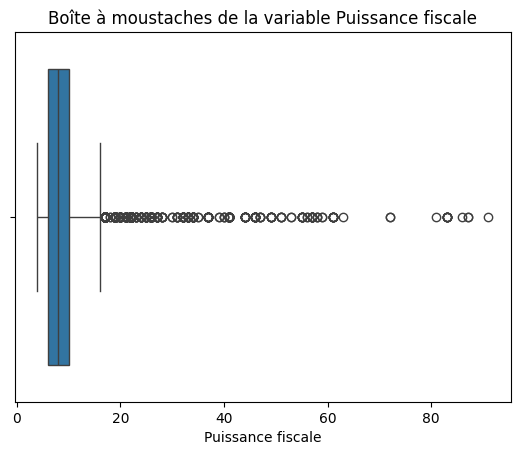

count    7409.000000
mean       10.229856
std         7.806961
min         4.000000
25%         6.000000
50%         8.000000
75%        10.000000
max        91.000000
Name: Puissance fiscale, dtype: float64


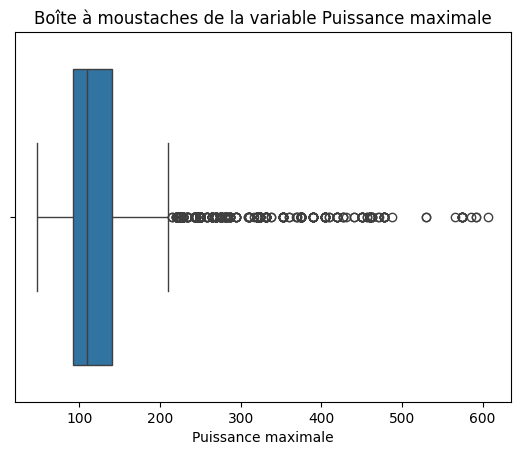

count    7409.000000
mean      130.021055
std        66.386992
min        48.000000
25%        91.900000
50%       110.000000
75%       140.000000
max       607.000000
Name: Puissance maximale, dtype: float64


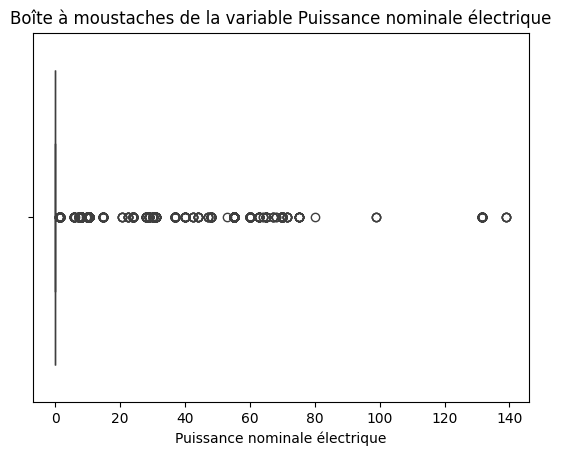

count    7409.000000
mean        6.757998
std        18.413563
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       139.000000
Name: Puissance nominale électrique, dtype: float64


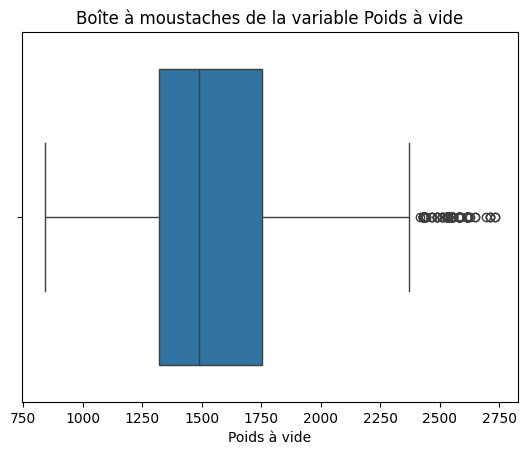

count    7409.000000
mean     1555.344986
std       333.232021
min       840.000000
25%      1320.000000
50%      1490.000000
75%      1755.000000
max      2735.000000
Name: Poids à vide, dtype: float64


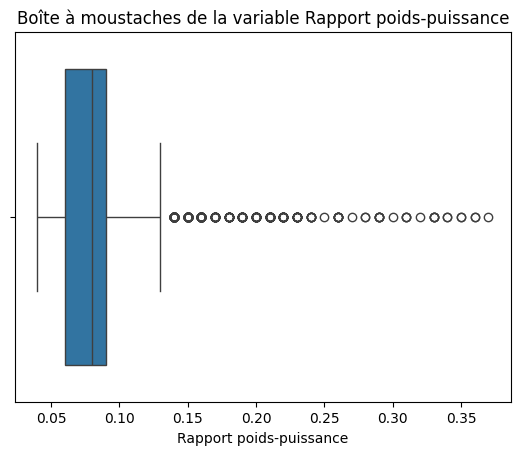

count    7409.000000
mean        0.082061
std         0.031618
min         0.040000
25%         0.060000
50%         0.080000
75%         0.090000
max         0.370000
Name: Rapport poids-puissance, dtype: float64


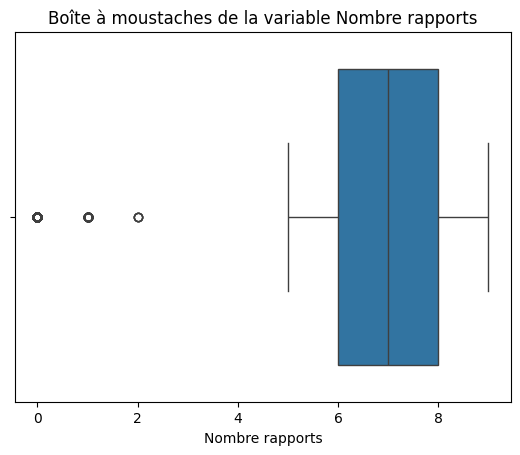

count    7409.000000
mean        6.928195
std         1.553918
min         0.000000
25%         6.000000
50%         7.000000
75%         8.000000
max         9.000000
Name: Nombre rapports, dtype: float64


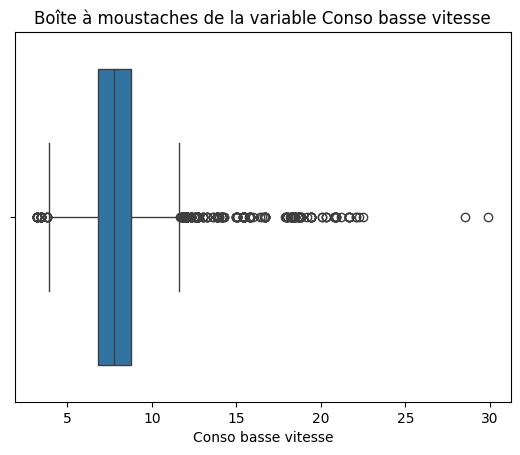

count    7409.000000
mean        7.994275
std         2.128792
min         3.219000
25%         6.807000
50%         7.765000
75%         8.740500
max        29.914500
Name: Conso basse vitesse, dtype: float64


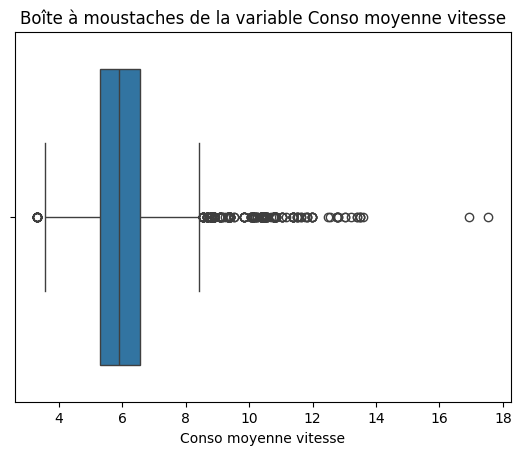

count    7409.000000
mean        6.059746
std         1.192675
min         3.327000
25%         5.308500
50%         5.912500
75%         6.555000
max        17.541500
Name: Conso moyenne vitesse, dtype: float64


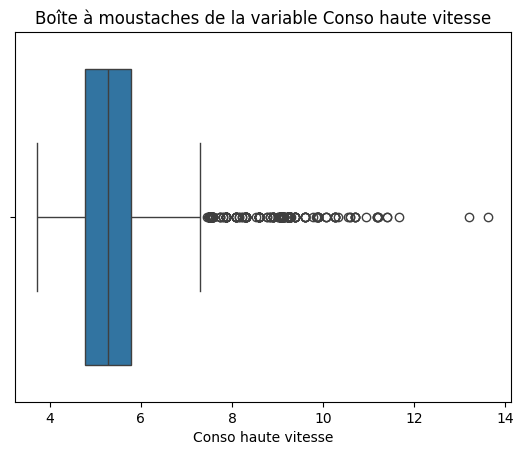

count    7409.000000
mean        5.394037
std         0.977377
min         3.726000
25%         4.761000
50%         5.267500
75%         5.778500
max        13.632000
Name: Conso haute vitesse, dtype: float64


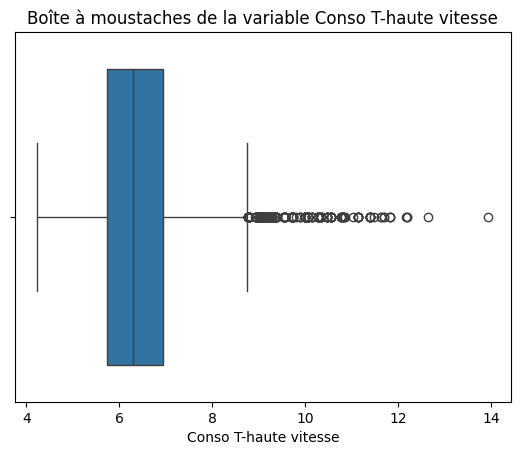

count    7409.000000
mean        6.447842
std         1.080364
min         4.238500
25%         5.733500
50%         6.296000
75%         6.940000
max        13.947000
Name: Conso T-haute vitesse, dtype: float64


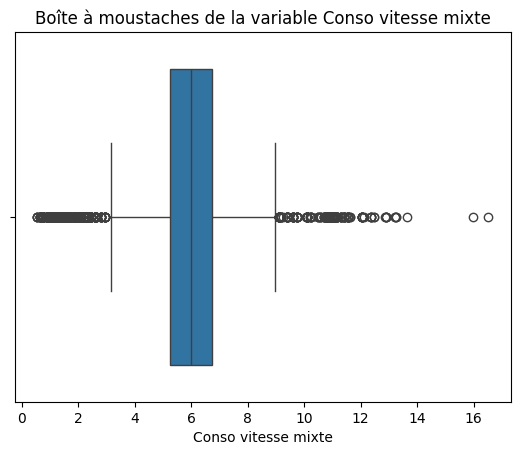

count    7409.000000
mean        5.898809
std         1.704561
min         0.562000
25%         5.256000
50%         5.987000
75%         6.746500
max        16.521500
Name: Conso vitesse mixte, dtype: float64


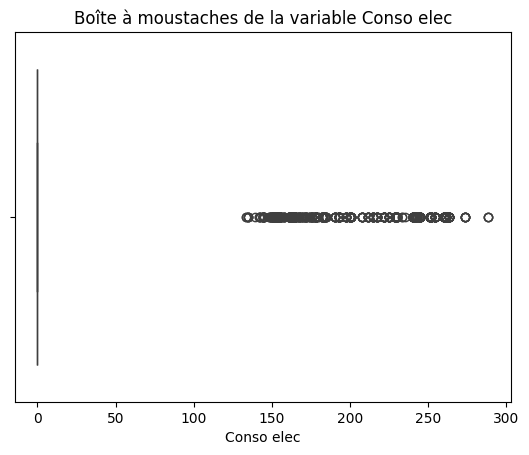

count    7409.000000
mean       16.028831
std        55.477397
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       288.500000
Name: Conso elec, dtype: float64


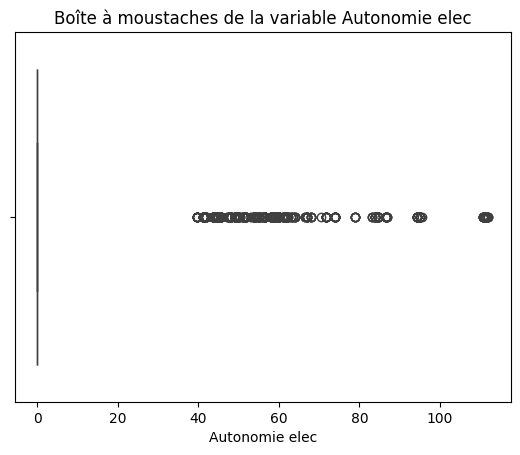

count    7409.000000
mean        4.950236
std        17.564573
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       112.000000
Name: Autonomie elec, dtype: float64


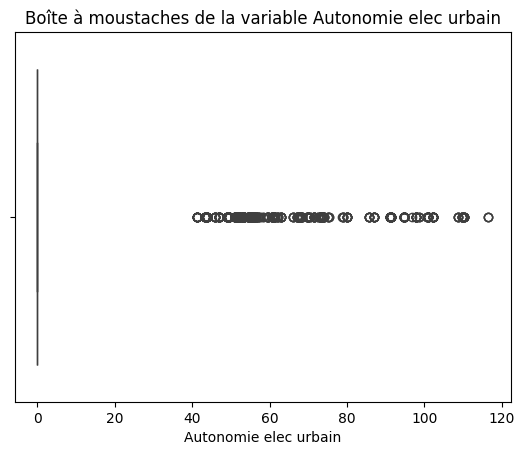

count    7409.000000
mean        5.455918
std        19.324330
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       116.500000
Name: Autonomie elec urbain, dtype: float64


In [21]:
for col in numerical:
    numerical_analysis(df, col)

### 2) Analyse bivariée

#### Variables quantitatives

In [22]:
numerical.append("Emission CO2")

- Matrice de corrélation

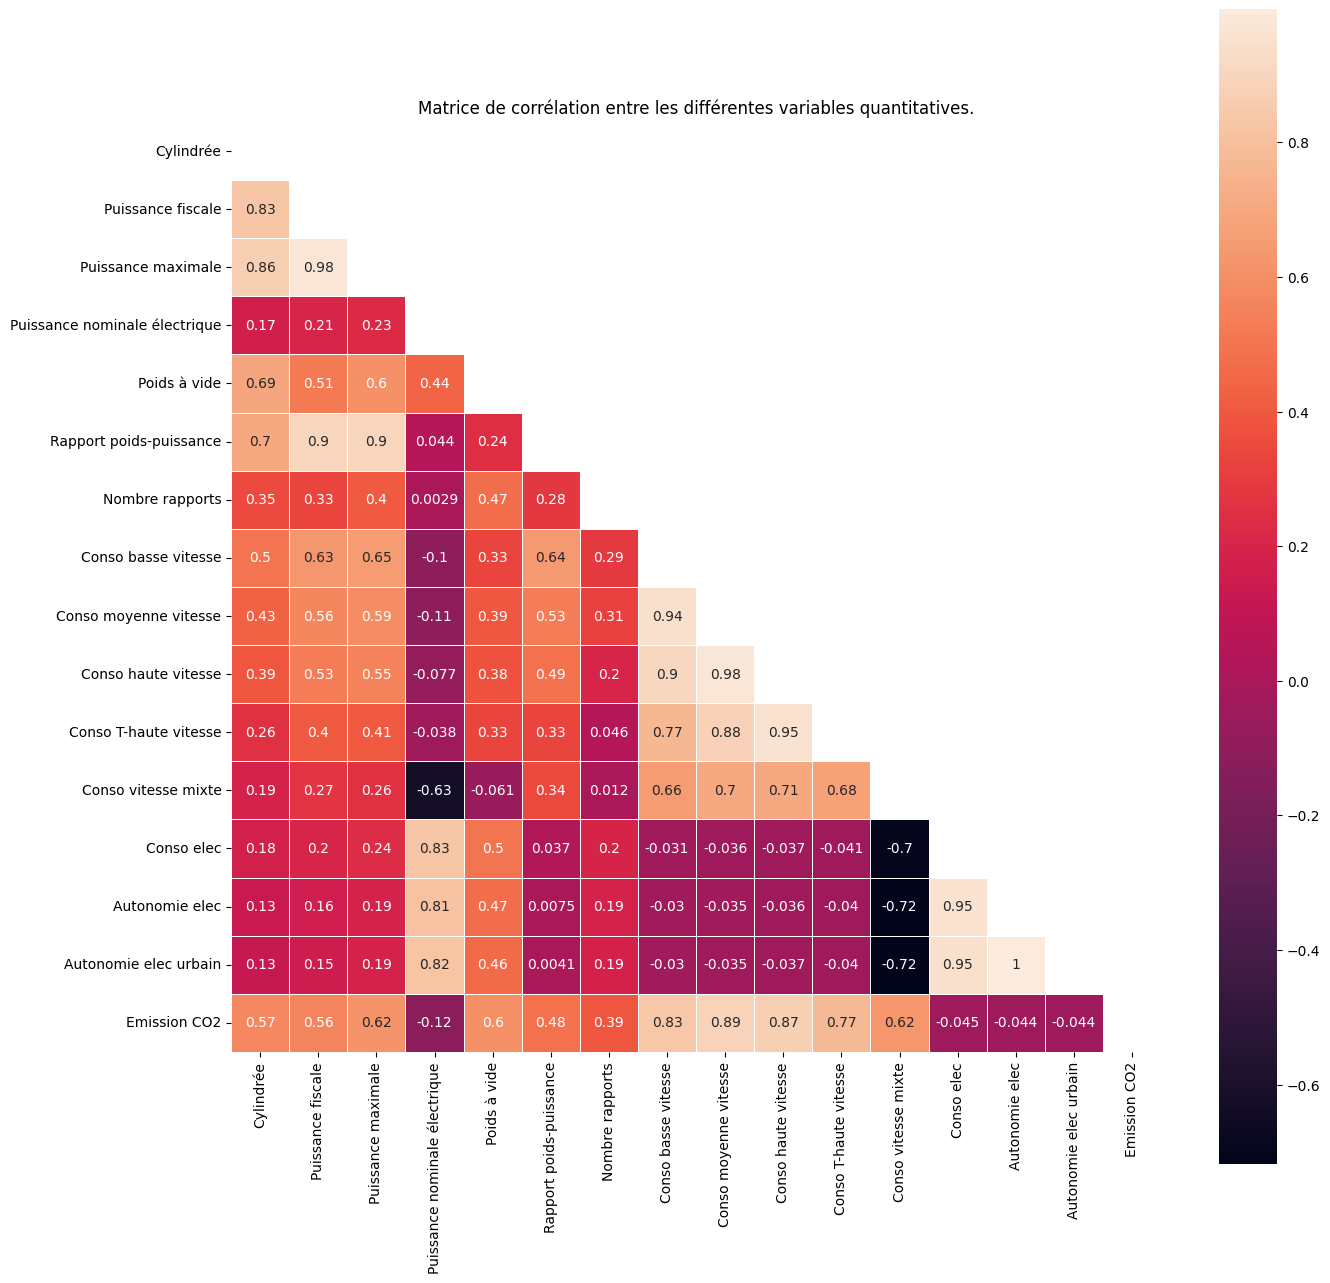

In [23]:
corr_matrix = df[numerical].corr()
mask = np.triu(corr_matrix)

plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, 
            mask=mask, 
            linewidths=.5, 
            annot=True, 
            cbar=True, 
            square=True)
plt.title("Matrice de corrélation entre les différentes variables quantitatives.")
plt.show()

In [24]:
# removing variables with poor correlation coefficient
del df["Puissance nominale électrique"]
del df["Conso elec"]
del df["Autonomie elec"]
del df["Autonomie elec urbain"]

In [25]:
variables_to_remove = ["Puissance nominale électrique", "Conso elec", "Autonomie elec", "Autonomie elec urbain", "Emission CO2"]
numerical = [x for x in numerical if x not in variables_to_remove]

- Régression linéaire entre émission de CO2 et les variables quantitatives

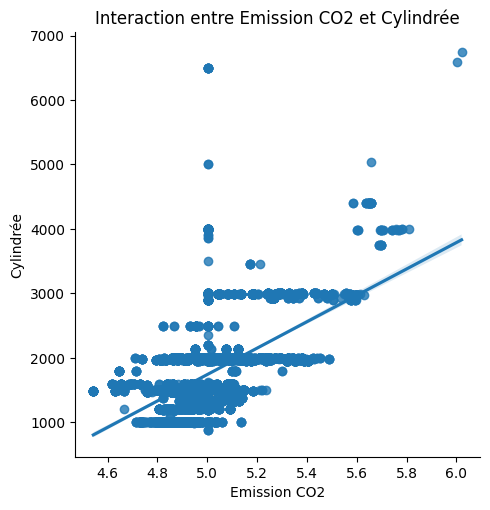

          names     coef      se      T  pval    r2  adj_r2  CI[2.5%]  \
0     Intercept -8498.77  171.92 -49.43   0.0  0.33    0.33  -8835.78   
1  Emission CO2  2047.59   34.17  59.92   0.0  0.33    0.33   1980.60   

   CI[97.5%]  
0   -8161.75  
1    2114.58  


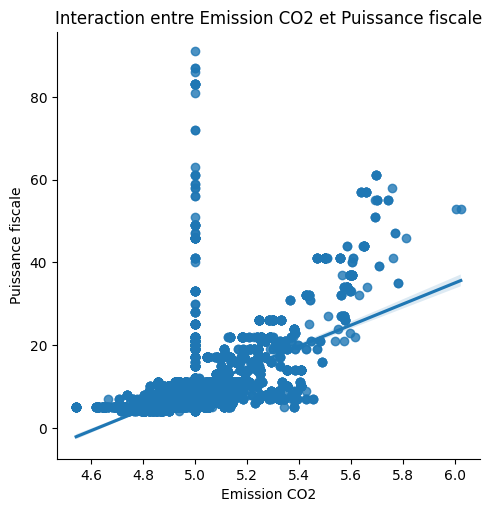

          names    coef    se      T  pval    r2  adj_r2  CI[2.5%]  CI[97.5%]
0     Intercept -118.20  2.23 -53.07   0.0  0.31    0.31   -122.57    -113.83
1  Emission CO2   25.54  0.44  57.70   0.0  0.31    0.31     24.68      26.41


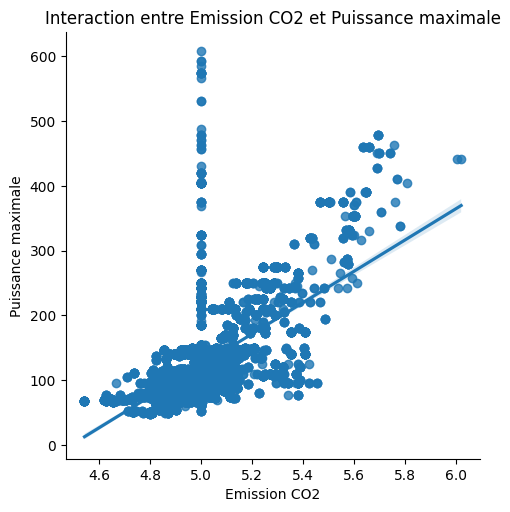

          names     coef     se      T  pval    r2  adj_r2  CI[2.5%]  \
0     Intercept -1082.16  17.92 -60.37   0.0  0.38    0.38  -1117.30   
1  Emission CO2   241.09   3.56  67.66   0.0  0.38    0.38    234.11   

   CI[97.5%]  
0   -1047.02  
1     248.08  


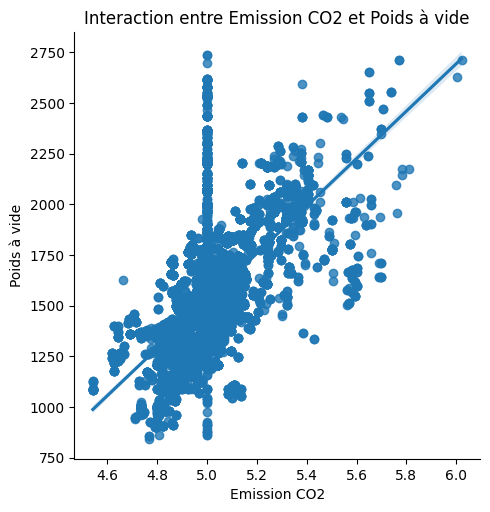

          names     coef     se      T  pval    r2  adj_r2  CI[2.5%]  \
0     Intercept -4331.39  91.74 -47.22   0.0  0.36    0.36  -4511.22   
1  Emission CO2  1170.83  18.24  64.21   0.0  0.36    0.36   1135.08   

   CI[97.5%]  
0   -4151.56  
1    1206.57  


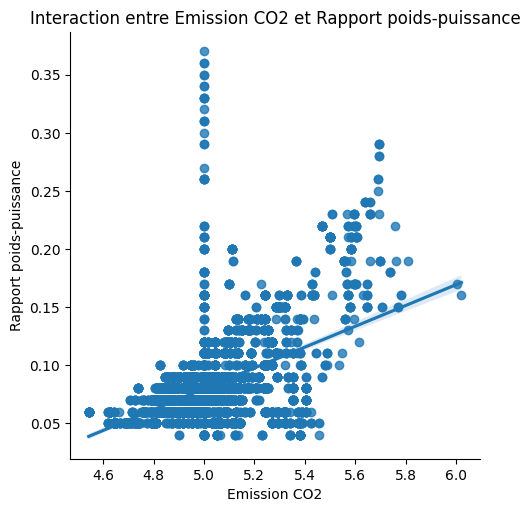

          names  coef    se      T  pval    r2  adj_r2  CI[2.5%]  CI[97.5%]
0     Intercept -0.37  0.01 -38.75   0.0  0.23    0.23     -0.39      -0.35
1  Emission CO2  0.09  0.00  47.40   0.0  0.23    0.23      0.09       0.09


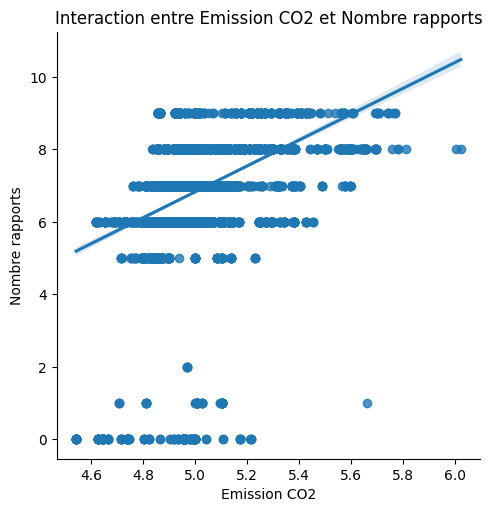

          names   coef    se      T  pval    r2  adj_r2  CI[2.5%]  CI[97.5%]
0     Intercept -11.05  0.49 -22.49   0.0  0.15    0.15    -12.01     -10.08
1  Emission CO2   3.58  0.10  36.62   0.0  0.15    0.15      3.38       3.77


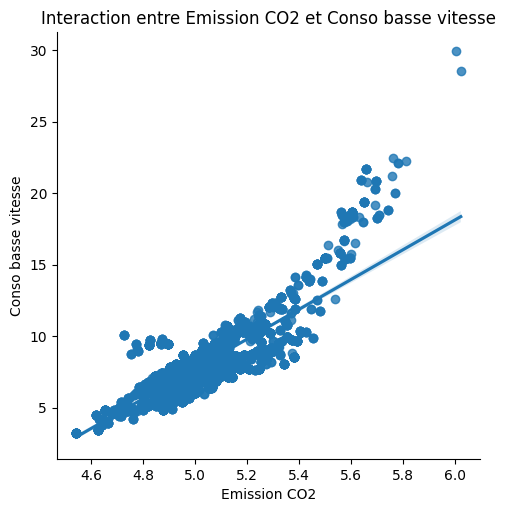

          names   coef    se       T  pval   r2  adj_r2  CI[2.5%]  CI[97.5%]
0     Intercept -44.46  0.40 -110.21   0.0  0.7     0.7    -45.25     -43.67
1  Emission CO2  10.43  0.08  130.10   0.0  0.7     0.7     10.28      10.59


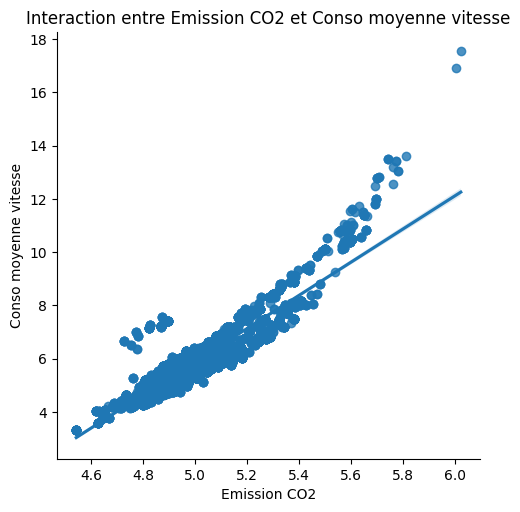

          names   coef    se       T  pval    r2  adj_r2  CI[2.5%]  CI[97.5%]
0     Intercept -25.30  0.19 -135.53   0.0  0.79    0.79    -25.67     -24.94
1  Emission CO2   6.24  0.04  168.09   0.0  0.79    0.79      6.17       6.31


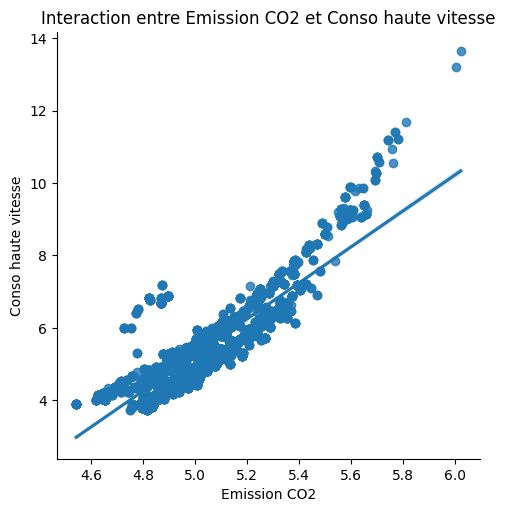

          names   coef    se       T  pval    r2  adj_r2  CI[2.5%]  CI[97.5%]
0     Intercept -19.61  0.17 -116.81   0.0  0.75    0.75    -19.94     -19.28
1  Emission CO2   4.97  0.03  149.02   0.0  0.75    0.75      4.91       5.04


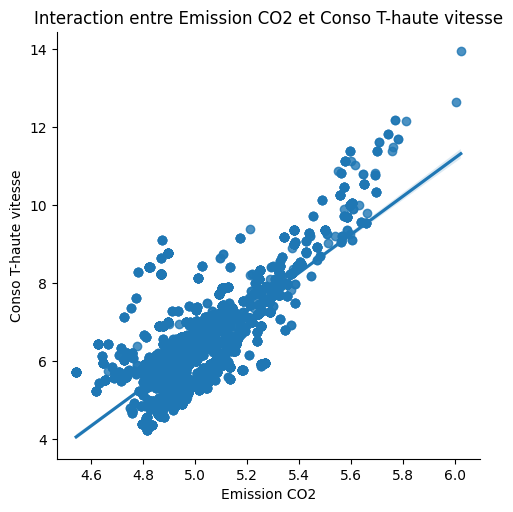

          names   coef    se       T  pval   r2  adj_r2  CI[2.5%]  CI[97.5%]
0     Intercept -18.24  0.24  -77.58   0.0  0.6     0.6    -18.70     -17.78
1  Emission CO2   4.91  0.05  105.06   0.0  0.6     0.6      4.82       5.00


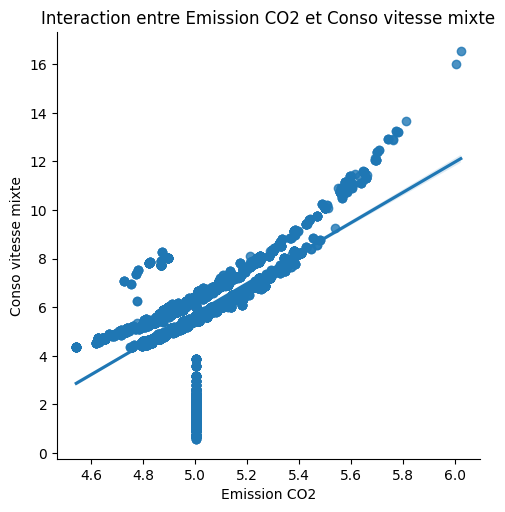

          names   coef    se      T  pval    r2  adj_r2  CI[2.5%]  CI[97.5%]
0     Intercept -25.54  0.46 -55.86   0.0  0.39    0.39    -26.44     -24.65
1  Emission CO2   6.25  0.09  68.80   0.0  0.39    0.39      6.08       6.43


In [26]:
for col in numerical:
    linear_regression_analysis(df, col, "Emission CO2")

### Variables catégorielles

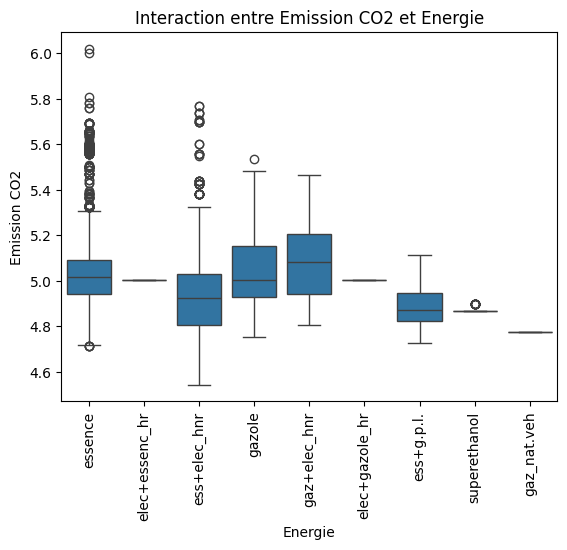

    Source      SS    DF    MS      F  p-unc   np2
0  Energie   14.38     8  1.80  66.45    0.0  0.07
1   Within  200.18  7400  0.03    NaN    NaN   NaN


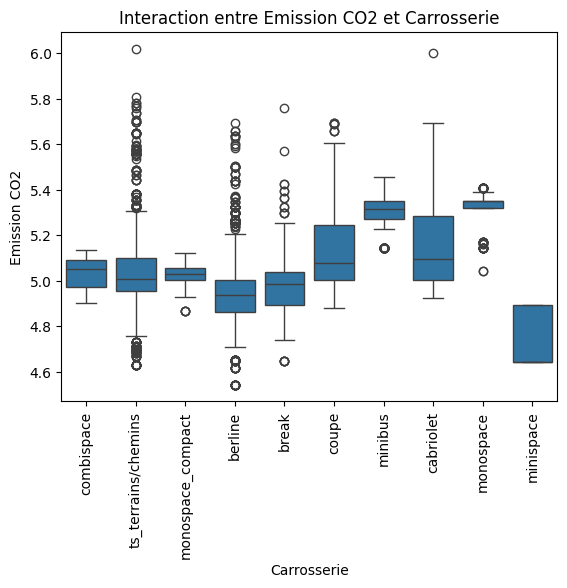

        Source      SS    DF    MS       F  p-unc   np2
0  Carrosserie   60.94     9  6.77  326.14    0.0  0.28
1       Within  153.62  7399  0.02     NaN    NaN   NaN


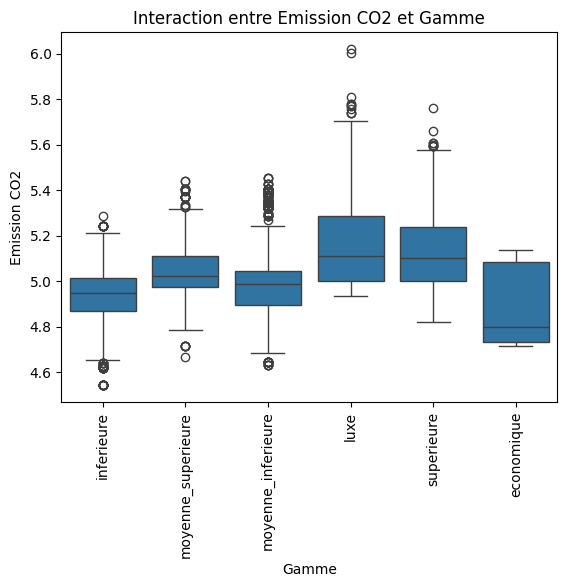

   Source      SS    DF     MS       F  p-unc   np2
0   Gamme   51.22     5  10.24  464.21    0.0  0.24
1  Within  163.35  7403   0.02     NaN    NaN   NaN


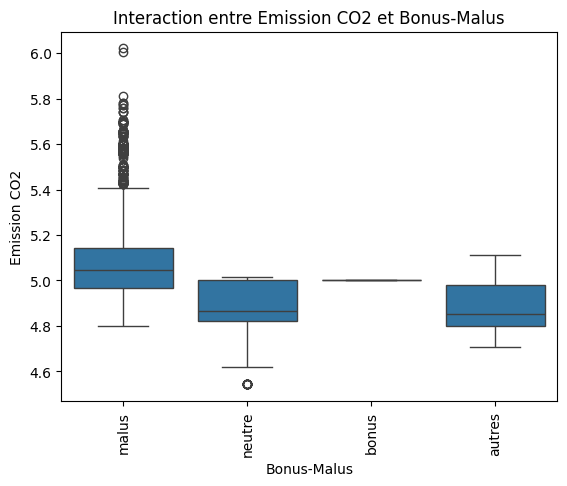

        Source      SS    DF     MS       F  p-unc   np2
0  Bonus-Malus   58.52     3  19.51  925.58    0.0  0.27
1       Within  156.05  7405   0.02     NaN    NaN   NaN


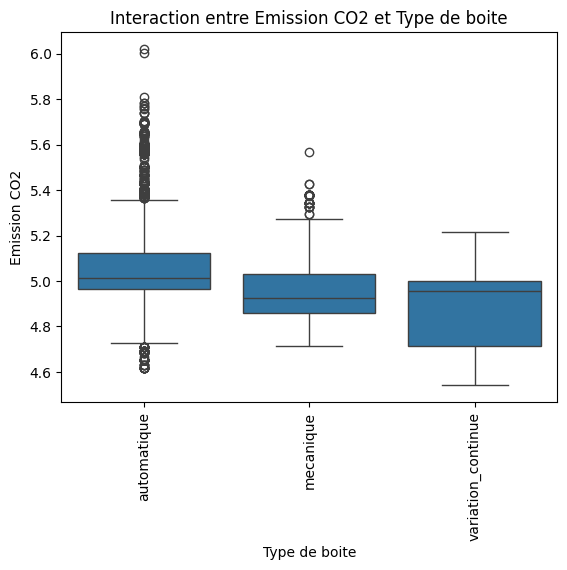

          Source      SS    DF     MS       F  p-unc   np2
0  Type de boite   24.15     2  12.08  469.72    0.0  0.11
1         Within  190.41  7406   0.03     NaN    NaN   NaN


In [27]:
for col in ['Energie', 'Carrosserie', 'Gamme', 'Bonus-Malus', "Type de boite"]:
    categorical_relation(df, col, "Emission CO2")

## 3) Préparation des données pour modélisation

In [28]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [29]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [30]:
y_train = df_train["Emission CO2"].values
y_test = df_test["Emission CO2"].values

In [31]:
del df_train['Emission CO2']
del df_test['Emission CO2']

In [32]:
numerical = [i for i in list(df.columns) if i not in categorical]
numerical.pop(-1)

'Emission CO2'

In [33]:
train_dicts = df_train.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')

In [34]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_test = dv.transform(test_dicts)

### 4) Choix du modèle

#### Baseline

In [35]:
dummy = DummyRegressor(strategy="median")
dummy.fit(X_train, y_train)

DummyRegressor(strategy='median')

In [36]:
y_pred = dummy.predict(X_test)

In [37]:
rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 5)
mape = round(mean_absolute_percentage_error(y_test, y_pred), 5)
print(f"rmse : {rmse} & mape : {mape}")

rmse : 0.17302 & mape : 0.02332


In [38]:
del y_pred
del rmse
del mape
gc.collect()

33127

#### Random Forest Regressor

In [39]:
rf = RandomForestRegressor(random_state=42, 
                           n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [40]:
y_pred = rf.predict(X_test)

In [41]:
rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 5)
mape = round(mean_absolute_percentage_error(y_test, y_pred), 5)
print(f"rmse : {rmse} & mape : {mape}")

rmse : 0.00366 & mape : 0.00013


In [42]:
param_distribs = {
    "n_estimators" : [int(x) for x in np.linspace(50, 500, 10)],
    "max_depth" : [int(x) for x in np.linspace(5, 16, 10)],
    "min_samples_leaf" : randint(2, 10),
    "min_samples_split" : randint(2, 10),
    "bootstrap" : [True, False]
    
}

rf_rnd_search = RandomizedSearchCV(rf, 
                                   param_distributions=param_distribs,
                                   n_iter=100,
                                   cv=5,
                                   scoring="neg_mean_squared_error",
                                   random_state=42)
rf_rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 6, 7, 8, 9, 11, 12, 13,
                                                      14, 16],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7eff2c454290>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7eff2d0eda10>,
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 350, 400, 450,
                                                         500]},
                   random_state=42, scoring='neg_mean_squared_error')

In [43]:
rf_rnd_search.best_params_

{'bootstrap': True,
 'max_depth': 12,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 150}

In [44]:
params = [{
    "n_estimators" : [120, 130, 140, 150],
    "max_depth" : [11, 12, 13],
    "min_samples_leaf" : [2, 3],
    "min_samples_split" : [2, 3],
    "bootstrap" : [True]
}]

rf_grid_search = GridSearchCV(rf, 
                            params,
                            cv=5,
                            scoring="neg_mean_squared_error")
rf_grid_search.fit(X_train, 
                   y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             param_grid=[{'bootstrap': [True], 'max_depth': [11, 12, 13],
                          'min_samples_leaf': [2, 3],
                          'min_samples_split': [2, 3],
                          'n_estimators': [120, 130, 140, 150]}],
             scoring='neg_mean_squared_error')

In [45]:
rf_grid_search.best_params_

{'bootstrap': True,
 'max_depth': 13,
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 130}

In [46]:
rf = rf_grid_search.best_estimator_

In [47]:
y_pred = rf.predict(X_test)

In [48]:
rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 5)
mape = round(mean_absolute_percentage_error(y_test, y_pred), 5)
print(f"rmse : {rmse} & mape : {mape}")

rmse : 0.00532 & mape : 0.00021


In [49]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(by="importance", ascending=False).head(10)

,feature,importance
17,Conso moyenne vitesse,0.679214
340,Poids à vide,0.122906
18,Conso vitesse mixte,0.076291
16,Conso haute vitesse,0.040478
19,Cylindrée,0.022834
2,Bonus-Malus=malus,0.020000
15,Conso basse vitesse,0.014164
3,Bonus-Malus=neutre,0.009029
14,Conso T-haute vitesse,0.005201
22,Energie=ess+elec_hnr,0.001895
